# 3D detection from 2D images evaluation


In [21]:
import pickle
import warnings
import numpy as np
import pandas as pd
import math

import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import json

from typing import List

warnings.filterwarnings('ignore')
#%cd /workspaces/bev2seg_2/
%cd /home/VICOMTECH/agarciaj/GitLab/bev2seg_2

DATA_PATH = "./data/pipeline_3d_evaluations.pkl"
# Window = 5 and turning_threshold = 5.0 deg
TURNING_FLAGS_5DEG = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False]


/home/VICOMTECH/agarciaj/GitLab/bev2seg_2


## Evaluation Data Structure

```python
data = {
    'scene_name_eval0':{
        'openlabel_path': str,
        'model_config':{
            'scene':{
                'scene_path':...,
                'camera_name': 'CAM_FRONT'
            },
            'semantic':{
                'raw2segmodel_path': ...,
                'bev2segmodel_path': ...,
                'merge_semantic_labels_flag': True,
                'merge_dict': DEFAULT_MERGE_DICT,
            },
            'depth_estimation':{
                'depth_pro_path':...
            },
            'scene_pcd':{
            },
            'instance_scene_pcd':{
                'dbscan_samples': 15,
                'dbscan_eps': 0.1,
                'dbscan_jobs': None,
                'lims': (np.inf, np.inf, np.inf),
                'min_samples_per_instance': 250,
                'max_distance': 50.0,
                'max_height': 2.0
            }
        },
        'eval_config':{
            'camera_depth': 15.0,
            'max_association_distance': 7.0,
            'semantic_types': ['vehicle.car'],
            'ignoring_names': ['ego_vehicle']
        },
        'frames': {
            0: {
                'semantic_type':{
                    'num_gt_objs': 0,
                    'num_dt_objs': 0,
                    
                    'metrics':{
                        'tp': 0,
                        'fp': 0,
                        'fn': 0,
                        'dd': [...],
                        'ded': [...],
                        'IoU_v': [...],
                        'v2v_dist': [...],
                        'bbd': [...]
                    }
                }
            },
            ...
        }
        
    }
}
```

In [2]:
def show_evaluated_models(data:dict):
    evaluations = list(data.keys())
    results = []
    for e in evaluations:
        num_frames      = len(data[e]['frames'].keys())
        eval_config     = data[e]['eval_config']
        model_config    = data[e]['model_config']
        results.append([e, num_frames, json.dumps(eval_config, indent=4), json.dumps(model_config, indent=4)])
    res = tabulate(results, headers=['Evaluation Name', 'Num frames', 'eval_config', 'model_config'])

    print(f"\nSAVED EVALUATIONS IN {DATA_PATH}:")
    print(res)

## Defined Functions

In [16]:
def best_grid_shape(num_plots):
    if num_plots == 1:
        return (1, 1)
    
    best_rows, best_cols = None, None
    min_diff = float('inf')  # Diferencia mínima entre filas y columnas
    
    for cols in range(1, math.ceil(math.sqrt(num_plots)) + 1):
        rows = math.ceil(num_plots / cols)
        diff = abs(rows - cols)  # Queremos minimizar la diferencia filas-columnas
        
        if diff < min_diff:
            min_diff = diff
            best_rows, best_cols = rows, cols
    
    return (best_rows, best_cols)

def get_metric_for_each_gt_obj(data:dict, eval_name:str, metric_name:str):
    assert eval_name in data
    distinct_gt_uids = {}
    last_fk = 0
    for fk in data[eval_name]['frames'].keys():
        for tp in data[eval_name]['frames'][fk]:
            assignments = data[eval_name]['frames'][fk][tp]['assignments']
            gt_uids = data[eval_name]['frames'][fk][tp]['gt_uids']
            for idx, (i,_) in enumerate(assignments):
                if gt_uids[i] not in distinct_gt_uids:
                    distinct_gt_uids.update({gt_uids[i]: [0.0 if metric_name != 'ded' else (0.0, 0.0, 0.0) for _ in range(0, fk)]})
                metric = data[eval_name]['frames'][fk][tp]['metrics'][metric_name][idx]
                distinct_gt_uids[gt_uids[i]].append(metric)
        last_fk = fk

    # Fill frames where objects doesnt appear
    for k, v in distinct_gt_uids.items():
        fill_frames = last_fk-len(v) +1
        if fill_frames == 0:
            continue
        for _ in range(fill_frames):
            if metric_name == 'ded':
                v.append((0.0, 0.0, 0.0))
            else:
                v.append(0.0)
    
    all_equal = True
    for _, v in distinct_gt_uids.items():
        all_equal = all_equal and len(v) == last_fk+1
    assert all_equal
    return distinct_gt_uids

def show_metric_for_each_gt_obj(data:dict, 
                                eval_name:str, 
                                metric_name:str, 
                                yline:float=None, 
                                is_turning_frame: List[bool] = None,
                                straight_color:str  = "#00A697",
                                turning_color:str   = "#C00071"):
    distinct_gt_uids = get_metric_for_each_gt_obj(data, eval_name, metric_name)
    uids = list(distinct_gt_uids.keys())

    cmap_turning = ListedColormap([straight_color, turning_color])

    num_plots = len(uids)
    rows, cols = best_grid_shape(num_plots)
    rows, cols = 1, num_plots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=False, sharey=True) 
    if rows == 1:
        axes = np.array(axes).reshape(1, -1)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]  # Selecciona el subplot correcto
        if i < num_plots:
            y = distinct_gt_uids[uids[i]]
            x = list(range(0, len(y)))

            ax.set_title(uids[i])

            if metric_name != "ded":
                ax.bar(x, y, color='orange')
            else:
                y = np.array(y).reshape((len(y), 3))
                ax.bar(x, y[:, 0], color='red', label='x')
                ax.bar(x, y[:, 1], color='green', label='y')
                ax.bar(x, y[:, 2], color='blue', label='z')

            if yline is not None:
                ax.axhline(y=yline, color="red")
            ax.set_xlabel("Frame")
            ax.set_ylabel(metric_name.upper())
            ax.legend()

            if is_turning_frame is not None and len(is_turning_frame) == len(x):
                turning_values = np.array(is_turning_frame).astype(int).reshape(1, -1)

                # Crea un pequeño eje incrustado en la parte inferior del eje principal
                # [x, y, ancho, alto] - coordenadas relativas al eje padre (0 a 1)
                # El ancho se corresponde con el ancho del eje padre (1.0),
                # el alto es pequeño (0.02) y la posición y es negativa para sacarlo fuera.
                inset_ax = ax.inset_axes([0, -0.05, 1, 0.025], transform=ax.transAxes) # Ajustado [x, y, width, height]

                # Dibuja la imagen en este nuevo eje
                # extent se refiere a las coordenadas de datos del *nuevo* eje,
                # así que aquí [0, len(x_data), 0, 1] mapea los valores 0..len(x_data)-1
                # a todo el ancho del inset_ax.
                inset_ax.imshow(turning_values, aspect='auto',
                                extent=[x[0] - 0.5, x[-1] + 0.5, 0, 1],
                                cmap=cmap_turning,
                                vmin=0, vmax=1)

                # Elimina los ticks y spines del eje incrustado para que solo se vea la barra de color
                inset_ax.set_xticks([])
                inset_ax.set_yticks([])
                inset_ax.spines['top'].set_visible(False)
                inset_ax.spines['right'].set_visible(False)
                inset_ax.spines['left'].set_visible(False)
                inset_ax.spines['bottom'].set_visible(False)
                
                # Ajusta el layout de las etiquetas del eje principal para evitar solapamiento
                ax.tick_params(axis='x', which='major', pad=10)

        else:
            ax.axis("off")  # Apagar los subplots extra
    plt.tight_layout()
    plt.show()


def get_frame_groups_from_flags(flag_list: List[bool]) -> List[List[int]]:
    """
    Groups consecutive identical boolean flags into sublists of their original indices.
    Args:
        flag_list: A list of boolean flags.
    Returns:
        A list of lists, where each inner list contains the indices of consecutive
        frames that share the same flag value.
    Example:
        input_example   = [True, True, True, False, False, False, False, True, True, True]
        output_example  = [ [0, 1, 2], [3, 4, 5, 6], [7, 8, 9] ]
    """
    if not flag_list:
        return []
    groups: List[List[int]] = []
    current_group: List[int] = []
    current_flag_value = flag_list[0]
    for i, flag in enumerate(flag_list):
        if flag == current_flag_value:
            current_group.append(i)
        else:
            groups.append(current_group)
            current_group = [i]
            current_flag_value = flag
    # Add the last group after the loop finishes
    if current_group:
        groups.append(current_group)
    # Assertion to ensure all input indices are covered in the output
    all_input_indices = set(range(len(flag_list)))
    all_output_indices = set()
    for group in groups:
        for idx in group:
            all_output_indices.add(idx)
    assert all_input_indices == all_output_indices, "Not all input indices are present in the output groups."
    return groups
def generate_latex_metric_table(data:dict, 
                             eval_name:str,
                             metric_names:List[str], 
                             frame_groups:List[List[int]]=None, 
                             frame_group_labels:List[str]=None,
                             caption:str="Latex metrics table"):
    
    def check_groups(frame_keys:List[str]):
        for fk in frame_keys:
            fk = int(fk)
            fk_in_groups =  False
            for g in frame_groups:
                for e in g:
                    if e == fk:
                        fk_in_groups = True
                        continue
                if fk_in_groups:
                    continue
            assert fk_in_groups, f"frame key: {fk} is not pressent in groups"
    def get_frame_group(fk:int) -> int:
        group_index = -1
        for i, g in enumerate(frame_groups):
            if fk in g:
                group_index = i
        assert group_index != -1
        return group_index



    assert eval_name in data
    frame_keys = list(data[eval_name]['frames'].keys())
    num_frames = len(frame_keys)

    frame_groups = list( list(range(num_frames)) ) if frame_groups is None else frame_groups
    check_groups(frame_keys)
    num_groups = len(frame_groups)

    frame_group_labels = list(range(num_groups)) if frame_group_labels is None else frame_group_labels
    assert  len(frame_groups) == len(frame_group_labels)
    
    mean_metrics = np.zeros((num_groups, len(metric_names), 3)) # for DED metrix (x, y, z)
    
    N = 0
    for fk in frame_keys:
        group_index = get_frame_group(fk)
        for tp in data[eval_name]['frames'][fk]:
            # tp = semantic_type
            for metric_index, metric_name in enumerate(metric_names):
                
                assert metric_name in data[eval_name]['frames'][fk][tp]['metrics']
                metric_vals = data[eval_name]['frames'][fk][tp]['metrics'][metric_name]
                metric_vals = np.array(metric_vals)

                if metric_name == 'ded':

                    metric_vals = np.atleast_2d(metric_vals)
                    mean_metrics[group_index, metric_index, 0] += np.sum(metric_vals[:, 0]) # x
                    mean_metrics[group_index, metric_index, 1] += np.sum(metric_vals[:, 1]) # y
                    mean_metrics[group_index, metric_index, 2] += np.sum(metric_vals[:, 2]) # z 
                else:
                    mean_metrics[group_index, metric_index, :] += np.sum(metric_vals)
                N += len(metric_vals) # Num objects
    mean_metrics /= N

    # mean_metrics[num_group, metric_index, (x, y, z) for DED metric ]
    # print(mean_metrics)

    # --- LaTeX Table Generation ---
    latex_table = "\\begin{table}[h!]\n"
    latex_table += f"\\centering\n"

    # Define column headers
    header_cols = ["Track Segment"]
    for metric_name in metric_names:
        if metric_name == 'ded':
            header_cols.extend(['DED-x', 'DED-y', 'DED-z'])
        else:
            header_cols.append(metric_name.upper())

    num_cols = len(header_cols)
    latex_table += f"\\begin{{tabular}}{{|{'c|' * num_cols}}}\n"
    latex_table += "\\hline\n"
    latex_table += " & ".join(header_cols) + " \\\\\n"
    latex_table += "\\hline\n"

    # Add data rows
    for i in range(num_groups):
        row_values = [frame_group_labels[i]]
        for metric_index, metric_name in enumerate(metric_names):
            if metric_name == 'ded':
                # Format to 3 decimal places for consistency
                row_values.append(f"{mean_metrics[i, metric_index, 0]:.3f}") # x
                row_values.append(f"{mean_metrics[i, metric_index, 1]:.3f}") # y
                row_values.append(f"{mean_metrics[i, metric_index, 2]:.3f}") # z
            else:
                row_values.append(f"{mean_metrics[i, metric_index, 0]:.3f}") # Other metrics, just take first value

        latex_table += " & ".join(row_values) + " \\\\\n"
        latex_table += "\\hline\n"

    latex_table += "\\end{tabular}\n"
    latex_table += f"\\caption{{{caption}}}\n"
    latex_table += "\\label{tab:metrics}\n"
    latex_table += "\\end{table}\n"

    return latex_table



## Results Visualization

In [5]:
data = None
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

show_evaluated_models(data)


SAVED EVALUATIONS IN ./data/pipeline_3d_evaluations.pkl:
Evaluation Name      Num frames  eval_config                           model_config
-----------------  ------------  ------------------------------------  ------------------------------------------------------------------------------------
scene-0061                   39  {                                     {
                                     "camera_depth": 30.0,                 "scene": {
                                     "max_association_distance": 3.0,          "scene_path": "tmp/scene-0061",
                                     "association_dist_type": "v2v",           "camera_name": "CAM_FRONT"
                                     "semantic_types": [                   },
                                         "vehicle.car"                     "semantic": {
                                     ],                                        "raw2segmodel_path": "models/segformer_nu_formatted/raw2segbev_mit-b0_v0.3",
   

In [58]:
data['scene-0061']['frames'][9]

{'vehicle.car': {'gt_uids': ['37', '154', '138'],
  'dt_uids': ['445', '446', '448'],
  'assignments': [(0, 1), (1, 0), (2, 2)],
  'metrics': {'tp': 3,
   'fp': 0,
   'fn': 0,
   'dd': [5.682320202261455, 5.499466494239435, 16.403148386931836],
   'ded': [(0.11290050506591776, 0.8357379989624023, 0.016390371084213262),
    (2.1229865570068363, 0.8621611051559448, 0.2732105083465577),
    (3.3931218719482423, 1.2779896850585937, 1.5719615366458894)],
   'IoU_v': [0.000914115631235779, 0.09589703300905723, 0.005242416312466705],
   'v2v_dist': [0.37142919323097584,
    0.23035459795185786,
    0.0022223713183022594],
   'bbd': [0.6285708067690241, 0.7696454020481421, 0.9977776286816977]}}}

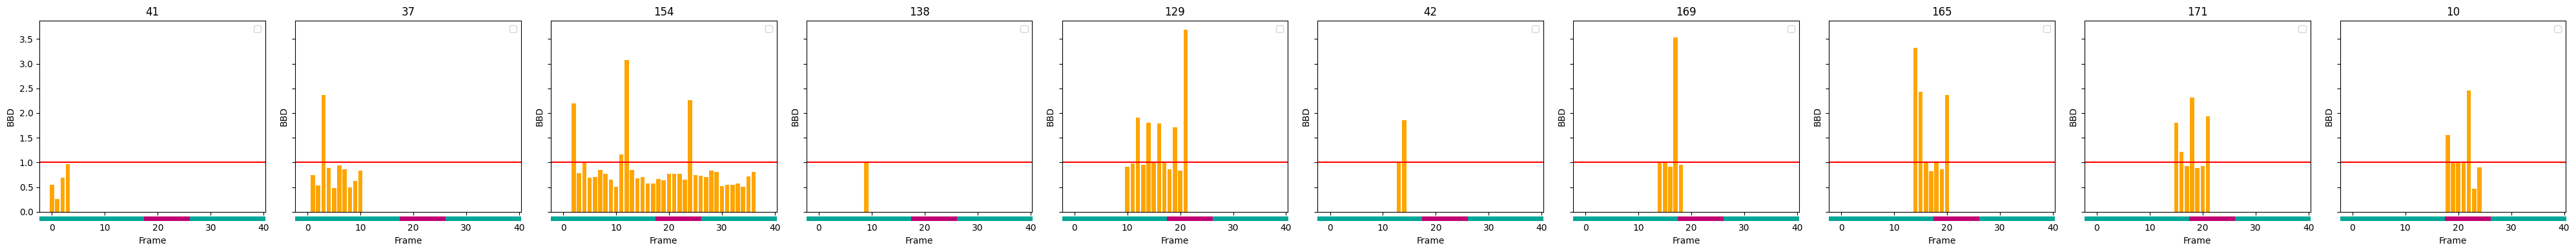

In [61]:
# show_metric_for_each_gt_obj(data, 'scene-0061', 'bbd', yline=1.0)
show_metric_for_each_gt_obj(data, 'scene-0061', 'bbd', yline=1.0, is_turning_frame=TURNING_FLAGS_5DEG)

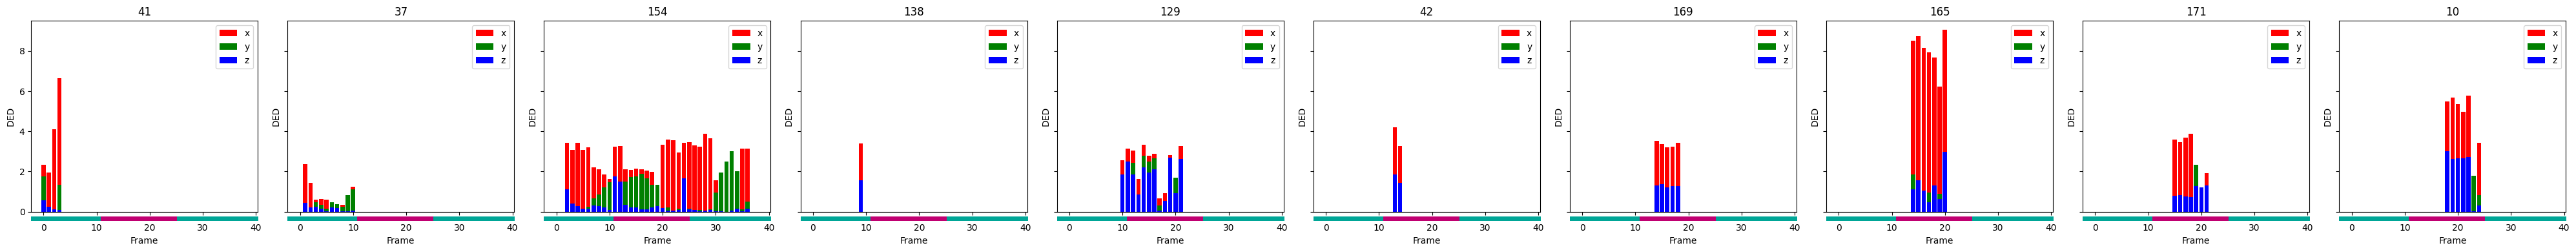

In [28]:
# show_metric_for_each_gt_obj(data, 'scene-0061', 'ded')
show_metric_for_each_gt_obj(data, 'scene-0061', 'ded', is_turning_frame=TURNING_FLAGS_CUSTOM)

In [31]:
TURNING_FLAGS_CUSTOM = [False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
frame_groups = get_frame_groups_from_flags(TURNING_FLAGS_5DEG)
frame_groups = get_frame_groups_from_flags(TURNING_FLAGS_CUSTOM)

latex_table = generate_latex_metric_table(data, 
                            'scene-0061', 
                            metric_names=[ 'ded' ], 
                            frame_groups=frame_groups, 
                            frame_group_labels=[ "Straight", "Turning", "Straight" ])
print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Track Segment & DED-x & DED-y & DED-z \\
\hline
Straight & 0.622 & 0.176 & 0.127 \\
\hline
Turning & 2.035 & 0.669 & 0.675 \\
\hline
Straight & 0.401 & 0.146 & 0.028 \\
\hline
\end{tabular}
\caption{Latex metrics table}
\label{tab:metrics}
\end{table}

